In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
def show_scrollable(df, max_rows=20, height=400, return_html=False):
    df = df.sort_values(['SessionId', 'turid'])
    cols = list(df.columns)
    if 'SessionId' in cols and 'turid' in cols:
        session_idx = cols.index('SessionId')
        cols.remove('turid')
        cols.insert(session_idx + 1, 'turid')
        df = df[cols]
    html = df.head(max_rows).to_html(notebook=True)
    full_html = f'<div style="overflow:auto; height:{height}px">{html}</div>'
    if return_html:
        return full_html
    else:
        display(HTML(full_html))

In [ ]:
OLD = pd.read_csv("Data/FastCheckTUData.csv", encoding='utf-8')
RAG = pd.read_csv("Data/RAG_corrected_df.csv", encoding='utf-8')
DET = pd.read_csv("Data/DET_final_corrected_df.csv", encoding='utf-8')

In [4]:
DET["SessionId"].nunique()

74596

In [5]:
OLD["SessionId"].nunique()

74596

### In the RAG we excluded public transports (transport middel above 20) during the training and the RAG itself, while in DET we emanually exclude them now, as well as in the initial data, to make them equally comparable

In [6]:
# Remove rows where transportmiddel > 25
OLD = OLD[OLD['transportmiddel'] <= 25]
DET = DET[DET['transportmiddel'] <= 25]
print(f"DET now has {len(DET)} rows after removing transportmiddel > 25")
print(f"OLD now has {len(OLD)} rows after removing transportmiddel > 25")

DET now has 234531 rows after removing transportmiddel > 25
OLD now has 234531 rows after removing transportmiddel > 25


In [7]:
# Also filter RAG to transportmiddel <= 25 for fair comparison
RAG = RAG[RAG['transportmiddel'] <= 25]
print(f"RAG now has {len(RAG)} rows after removing transportmiddel > 25")

RAG now has 234531 rows after removing transportmiddel > 25


In [8]:
show_scrollable(RAG, max_rows=3)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
0,347009,2118077,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",NaN,"Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",1.0,1.0,10.0,55.882587,12.490543,55.727110,12.584047,55.882587,12.490543,55.888063,12.493051,0.628716,0.000000,0.628716,False,False,False,trusted,"Below is an instruction that describes a task,...","Bellisvej 38, 2970 Hørsholm",55.882587,12.490543,1.0,"Ahornvej 30, 2970 Hørsholm",55.888061,12.493057,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN
1,347009,2118078,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",NaN,"bellisvej 38, 2970 hørsholm",11.0,1.0,3.0,55.882587,12.490543,55.727110,12.584047,55.888063,12.493051,55.882587,12.490543,0.628716,0.628716,0.000000,False,False,False,trusted,"Below is an instruction that describes a task,...","Ahornvej 30, 2970 Hørsholm",55.888061,12.493057,1.0,"Bellisvej 38, 2970 Hørsholm",55.882587,12.490543,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN
2,347010,2118081,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",NaN,"Keilstruplund 83, 3460 Birkerød",Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",11.0,5.0,10.0,55.839173,12.444784,55.930675,12.348036,55.839173,12.444784,55.851356,12.489082,3.079457,0.000000,3.079457,False,False,False,trusted,"Below is an instruction that describes a task,...","Keilstruplund 83, 3460 Birkerød",55.839170,12.444778,1.0,"Gøngehusvej 286, 2970 Hørsholm",55.851360,12.489075,0.937413,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,VALID,NaN,NaN,NaN


In [9]:
show_scrollable(DET, max_rows=3)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,daystartmuncode,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,corrected_dist_km,corrected_time_min,note_correction
0,347009,2118077,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",NaN,"Bellisvej 38, 2970 Hørsholm",NaN,Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",1.0,1.0,10.0,55.882587,12.490543,55.727110,12.584047,55.882587,12.490543,55.888063,12.493051,0.628716,0.000000,0.628716,False,False,False,trusted,NaN,NaN,NaN
1,347009,2118078,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",NaN,NaN,"bellisvej 38, 2970 hørsholm",11.0,1.0,3.0,55.882587,12.490543,55.727110,12.584047,55.888063,12.493051,55.882587,12.490543,0.628716,0.628716,0.000000,False,False,False,trusted,NaN,NaN,NaN
2,347010,2118081,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",NaN,"Keilstruplund 83, 3460 Birkerød",NaN,Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",11.0,5.0,10.0,55.839173,12.444784,55.930675,12.348036,55.839173,12.444784,55.851356,12.489082,3.079457,0.000000,3.079457,False,False,False,trusted,NaN,NaN,NaN


In [10]:
print('Unique SessionId in RAG:', RAG['SessionId'].nunique())
print('Unique SessionId in DET:', DET['SessionId'].nunique())

Unique SessionId in RAG: 74383
Unique SessionId in DET: 74383


In [11]:
RAG.columns

Index(['SessionId', 'homeText_raw', 'workText_raw', 'startDayText_raw',
       'startstedadrsogeord', 'startTripText_raw', 'turid', 'tiladrsogeord',
       'tiladrtext_raw', 'transportmiddel', 'stagelength_raw',
       'stagedurationmin_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon',
       'start_lat', 'start_lon', 'til_lat', 'til_lon', 'calc_dist_geo',
       'dist_start_home', 'dist_end_home', 'flag_coords_bad', 'flag_speed_bad',
       'flag_zero_dist', 'validation_status', 'prompt_text',
       'rag_start_address', 'rag_start_lat', 'rag_start_lon', 'rag_start_conf',
       'rag_end_address', 'rag_end_lat', 'rag_end_lon', 'rag_end_conf',
       'rag_prompt_text', 'llm_full_response', 'llm_verdict',
       'corrected_dist_km', 'corrected_time_min', 'note_correction'],
      dtype='object')

In [12]:
DET.columns

Index(['SessionId', 'homeText_raw', 'workText_raw', 'startDayText_raw',
       'startstedadrsogeord', 'startTripText_raw', 'daystartmuncode', 'turid',
       'tiladrsogeord', 'tiladrtext_raw', 'transportmiddel', 'stagelength_raw',
       'stagedurationmin_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon',
       'start_lat', 'start_lon', 'til_lat', 'til_lon', 'calc_dist_geo',
       'dist_start_home', 'dist_end_home', 'flag_coords_bad', 'flag_speed_bad',
       'flag_zero_dist', 'validation_status', 'corrected_dist_km',
       'corrected_time_min', 'note_correction'],
      dtype='object')

In [13]:
print("RAG llm_verdict counts:")
display(RAG['llm_verdict'].value_counts().to_frame())

print("\nDET validation_status counts:")
display(DET['validation_status'].value_counts().to_frame())

RAG llm_verdict counts:


,count
llm_verdict,
VALID,226464
corrected,8051
INVALID,16



DET validation_status counts:


,count
validation_status,
trusted,226993
corrected,7341
hard_wrong,197


In [14]:
# Since unique SessionIds match, compare per session
print(f"Unique SessionIds match: RAG {RAG['SessionId'].nunique()}, DET {DET['SessionId'].nunique()}")

# Group by SessionId and count rows and corrections
rag_session_stats = RAG.groupby('SessionId').agg(
    total_rows=('SessionId', 'size'),
    corrected=('llm_verdict', lambda x: (x == 'corrected').sum()),
    invalid=('llm_verdict', lambda x: x.isin(['INVALID', 'corrected']).sum())
).reset_index()

det_session_stats = DET.groupby('SessionId').agg(
    total_rows=('SessionId', 'size'),
    corrected=('validation_status', lambda x: (x == 'corrected').sum()),
    invalid=('validation_status', lambda x: x.isin(['hard_wrong', 'corrected']).sum())
).reset_index()

# Merge on SessionId
session_comparison = pd.merge(rag_session_stats, det_session_stats, on='SessionId', suffixes=('_rag', '_det'))

print(f"Session comparison shape: {session_comparison.shape}")
print(session_comparison.head())

Unique SessionIds match: RAG 74383, DET 74383


Session comparison shape: (74383, 7)
   SessionId  total_rows_rag  corrected_rag  invalid_rag  total_rows_det  \
0     347009               2              0            0               2   
1     347010               2              0            0               2   
2     347013               2              0            0               2   
3     347015               2              0            0               2   
4     347016               1              0            0               1   

   corrected_det  invalid_det  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  


In [15]:
# Now, analyze the session-level comparison
print("=== SESSION-LEVEL COMPARISON ===")
print(f"Average rows per session - RAG: {session_comparison['total_rows_rag'].mean():.2f}, DET: {session_comparison['total_rows_det'].mean():.2f}")
print(f"Average corrected per session - RAG: {session_comparison['corrected_rag'].mean():.2f}, DET: {session_comparison['corrected_det'].mean():.2f}")
print(f"Average invalid per session - RAG: {session_comparison['invalid_rag'].mean():.2f}, DET: {session_comparison['invalid_det'].mean():.2f}")

# Correlation between corrections
corr_corrected = session_comparison['corrected_rag'].corr(session_comparison['corrected_det'])
print(f"Correlation in corrected counts: {corr_corrected:.3f}")

# Sessions where RAG corrected more than DET
more_rag = (session_comparison['corrected_rag'] > session_comparison['corrected_det']).sum()
more_det = (session_comparison['corrected_rag'] < session_comparison['corrected_det']).sum()
equal = (session_comparison['corrected_rag'] == session_comparison['corrected_det']).sum()
print(f"Sessions with more corrections in RAG: {more_rag}")
print(f"Sessions with more corrections in DET: {more_det}")
print(f"Sessions with equal corrections: {equal}")

# Perhaps plot histograms or something, but for now, summary

=== SESSION-LEVEL COMPARISON ===
Average rows per session - RAG: 3.15, DET: 3.15
Average corrected per session - RAG: 0.11, DET: 0.10
Average invalid per session - RAG: 0.11, DET: 0.10
Correlation in corrected counts: 0.965
Sessions with more corrections in RAG: 524
Sessions with more corrections in DET: 9
Sessions with equal corrections: 73850


In [16]:
# Overall comparison stats (per session)
print("=== OVERALL STATS (PER SESSION) ===")
total_sessions = len(session_comparison)
total_rag_corrected = session_comparison['corrected_rag'].sum()
total_det_corrected = session_comparison['corrected_det'].sum()
total_rag_invalid = session_comparison['invalid_rag'].sum()
total_det_invalid = session_comparison['invalid_det'].sum()

print(f"Total sessions: {total_sessions}")
print(f"Total RAG corrected: {total_rag_corrected} ({total_rag_corrected / session_comparison['total_rows_rag'].sum():.2%})")
print(f"Total DET corrected: {total_det_corrected} ({total_det_corrected / session_comparison['total_rows_det'].sum():.2%})")
print(f"Total RAG invalid/corrected: {total_rag_invalid}")
print(f"Total DET invalid/corrected: {total_det_invalid}")

=== OVERALL STATS (PER SESSION) ===
Total sessions: 74383
Total RAG corrected: 8051 (3.43%)
Total DET corrected: 7341 (3.13%)
Total RAG invalid/corrected: 8067
Total DET invalid/corrected: 7538


## For better comparing the results, we standardize the terminology

In [17]:
DET['validation_status'] = DET['validation_status'].replace('hard_wrong', 'invalid')
RAG['llm_verdict'] = RAG['llm_verdict'].replace('INVALID', 'invalid')
RAG['llm_verdict'] = RAG['llm_verdict'].replace('VALID', 'trusted')

In [18]:
# Merge RAG and DET for row-level comparison
disagreements = pd.merge(RAG, DET, on='turid', suffixes=('_RAG', '_DET'))

# Rename columns to MultiIndex as expected
disagreements.columns = pd.MultiIndex.from_tuples([('RAG', col.replace('_RAG', '')) if '_RAG' in col else (('DET', col.replace('_DET', '')) if '_DET' in col else ('RAG', col)) for col in disagreements.columns])

# Add categories
disagreements['rag_cat'] = disagreements[('RAG', 'llm_verdict')].apply(lambda x: 'corrected' if x == 'corrected' else ('trusted' if x == 'trusted' else 'invalid'))
disagreements['det_cat'] = disagreements[('DET', 'validation_status')].apply(lambda x: 'corrected' if x == 'corrected' else ('trusted' if x == 'trusted' else 'invalid'))

# Show examples where RAG corrected but DET didn't (RAG corrected, DET not corrected, i.e., invalid or trusted)
rag_corrected_det_not = disagreements[(disagreements['rag_cat'] == 'corrected') & (disagreements['det_cat'].isin(['invalid', 'trusted']))]
print(f"RAG corrected, DET not corrected (invalid or trusted): {len(rag_corrected_det_not)} examples")
if not rag_corrected_det_not.empty:
    display_df = rag_corrected_det_not[[('RAG', 'SessionId'), ('RAG', 'turid'), ('RAG', 'llm_verdict'), ('DET', 'validation_status')]].copy()
    display_df.columns = ['SessionId', 'turid', 'llm_verdict', 'validation_status']
    display(display_df.head(5))

# DET corrected, RAG not corrected (invalid or trusted)
det_corrected_rag_not = disagreements[(disagreements['det_cat'] == 'corrected') & (disagreements['rag_cat'].isin(['invalid', 'trusted']))]
print(f"DET corrected, RAG not corrected (invalid or trusted): {len(det_corrected_rag_not)} examples")
if not det_corrected_rag_not.empty:
    display_df = det_corrected_rag_not[[('RAG', 'SessionId'), ('RAG', 'turid'), ('RAG', 'llm_verdict'), ('DET', 'validation_status')]].copy()
    display_df.columns = ['SessionId', 'turid', 'llm_verdict', 'validation_status']
    display(display_df.head(5))

# Both not corrected (neither corrected, i.e., both invalid or trusted)
both_not_corrected = disagreements[(disagreements['rag_cat'].isin(['invalid', 'trusted'])) & (disagreements['det_cat'].isin(['invalid', 'trusted']))]
print(f"Both not corrected (neither corrected, i.e., invalid or trusted): {len(both_not_corrected)} examples")
if not both_not_corrected.empty:
    display_df = both_not_corrected[[('RAG', 'SessionId'), ('RAG', 'turid'), ('RAG', 'llm_verdict'), ('DET', 'validation_status')]].copy()
    display_df.columns = ['SessionId', 'turid', 'llm_verdict', 'validation_status']
    display(display_df.head(5))

RAG corrected, DET not corrected (invalid or trusted): 1009 examples


,SessionId,turid,llm_verdict,validation_status
253,347159,2118403,corrected,trusted
466,347271,2118667,corrected,trusted
469,347271,2118670,corrected,trusted
470,347271,2118671,corrected,trusted
865,347479,2119244,corrected,invalid


DET corrected, RAG not corrected (invalid or trusted): 59 examples


,SessionId,turid,llm_verdict,validation_status
2784,348444,2121836,invalid,corrected
3283,348628,2122363,invalid,corrected
6545,350095,2126744,trusted,corrected
26114,358546,2151888,trusted,corrected
26122,358546,2151888,trusted,corrected


Both not corrected (neither corrected, i.e., invalid or trusted): 289682 examples


,SessionId,turid,llm_verdict,validation_status
0,347009,2118077,trusted,trusted
1,347009,2118078,trusted,trusted
2,347010,2118081,trusted,trusted
3,347010,2118082,trusted,trusted
4,347013,2118083,trusted,trusted


In [19]:
# Create dataframes for the wrong (uncorrected invalid) rows
det_wrong = DET[DET['validation_status'] == 'invalid']
rag_wrong = RAG[RAG['llm_verdict'] == 'invalid']

print(f"DET wrong rows: {len(det_wrong)}")
print(f"RAG wrong rows: {len(rag_wrong)}")

# Optionally, save
# det_wrong.to_csv('Data/det_wrong.csv', index=False)
# rag_wrong.to_csv('Data/rag_wrong.csv', index=False)

DET wrong rows: 197
RAG wrong rows: 16


In [20]:
# Create a df from RAG with only turid present in det_wrong
rag_for_det_wrong = RAG[RAG['turid'].isin(det_wrong['turid'])]

print(f"RAG rows for DET wrong turids: {len(rag_for_det_wrong)}")
print(rag_for_det_wrong['llm_verdict'].value_counts())

RAG rows for DET wrong turids: 255
llm_verdict
corrected    199
trusted       53
invalid        3
Name: count, dtype: int64


In [21]:
rag_for_det_wrong.to_csv('rag_for_det_wrong.csv', index=False)

In [22]:
det_corrected = DET[DET['validation_status'] == 'corrected']
rag_corrected = RAG[RAG['llm_verdict'] == 'corrected']

print(f"det_corrected has {len(det_corrected)} rows")
print(f"rag_corrected has {len(rag_corrected)} rows")

det_corrected has 7341 rows
rag_corrected has 8051 rows


In [23]:
show_scrollable(rag_corrected.head(5))

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
107,347096,2118225,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",11.0,7.0,15.0,54.834526,11.465634,54.662786,11.351456,54.662786,11.351456,0.000000,4.511256,6110.319369,20.454239,6130.283579,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","K. H. Kofoedsvej 6, 4970 Rødby",54.662618,11.357392,0.870392,"Kolby Hovedgade 8, 8305 Samsø",55.800105,10.555706,0.798605,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,211.6,230.0,osrm_recalc
108,347096,2118226,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...",11.0,7.0,15.0,54.834526,11.465634,54.662786,11.351456,0.000000,4.511256,54.662786,11.351456,6110.319369,6130.283579,20.454239,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Kolby Hovedgade 8, 8305 Samsø",55.800105,10.555706,0.798605,"K. H. Kofoedsvej 6, 4970 Rødby",54.662618,11.357392,0.870392,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,210.6,229.0,osrm_recalc
150,347115,2118279,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,NaN,"toftevangen 77, 4130 viby sjælland",Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,11.0,42.0,40.0,55.545711,12.032662,NaN,NaN,55.545711,12.032662,0.000000,4.511256,6213.935173,0.000000,6213.935173,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Toftevangen 77, 4130 Viby Sjælland",55.545709,12.032664,1.000000,"Stenagergårdsvej 31, 4160 Herlufmagle",55.300867,11.753039,0.887572,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,43.9,44.0,osrm_recalc
151,347115,2118280,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,NaN,"toftevangen 77, 4130 viby sjælland",11.0,42.0,40.0,55.545711,12.032662,NaN,NaN,0.000000,4.511256,55.545711,12.032662,6213.935173,6213.935173,0.000000,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Stenagergårdsvej 31, 4160 Herlufmagle",55.300867,11.753039,0.887572,"Toftevangen 77, 4130 Viby Sjælland",55.545709,12.032664,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,43.3,43.0,osrm_recalc
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg",1.0,1.0,2.0,56.178886,9.554954,NaN,NaN,56.178886,9.554954,56.183815,9.545761,0.789938,0.000000,0.789938,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Kejlstrupvej 15, 8600 Silkeborg",56.178882,9.554949,1.000000,"Nørrevænget 42, 8600 Silkeborg",56.183812,9.545765,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,1.0,13.0,osrm_recalc


In [24]:
det_corrected.head(5)

,SessionId,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,daystartmuncode,turid,tiladrsogeord,tiladrtext_raw,...,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,corrected_dist_km,corrected_time_min,note_correction
107,347096,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...",NaN,2118225,"Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",...,6110.319369,20.454239,6130.283579,True,False,False,corrected,295.3,248.0,start_fix(100);end_fix(64);osrm_recalc
108,347096,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",NaN,2118226,NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...",...,6110.319369,6130.283579,20.454239,True,False,False,corrected,294.6,248.0,start_fix(64);end_fix(100);osrm_recalc
150,347115,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,NaN,"toftevangen 77, 4130 viby sjælland",NaN,2118279,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,...,6213.935173,0.000000,6213.935173,True,False,False,corrected,4.1,7.0,start_fix(100);end_fix(60);osrm_recalc
151,347115,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,NaN,2118280,NaN,"toftevangen 77, 4130 viby sjælland",...,6213.935173,6213.935173,0.000000,True,False,False,corrected,4.1,7.0,start_fix(60);end_fix(100);osrm_recalc
227,347147,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,NaN,"kejlstrupvej 15, 8600 silkeborg",NaN,2118373,"Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg",...,0.789938,0.000000,0.789938,False,True,False,corrected,1.0,12.0,osrm_recalc


In [25]:
rag_zero_dist = RAG[(RAG['flag_zero_dist'] == True) & (RAG['llm_full_response'].str.contains('Speed'))]

print(f"rag_zero_dist has {len(rag_zero_dist)} rows")

rag_zero_dist has 46 rows


In [26]:
show_scrollable(rag_zero_dist)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction
11499,352419,2133440,"Porsevej 9, 4600 Køge","Porsevej 9, 4600 Køge",NaN,Kildebrønde,"´søndergaard´, kildebrønde landevej 41, 2670 g...",Kildebrønde,"´søndergaard´, kildebrønde landevej 41, 2670 g...",1.0,22.0,1.0,55.442478,12.160382,55.442478,12.160382,55.604998,12.265720,55.604998,12.265720,0.0,19.249352,19.249352,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Kildebrønde Landevej 41, 2670 Greve",55.605002,12.265713,0.854684,"Kildebrønde Landevej 41, 2670 Greve",55.605002,12.265713,0.854684,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
12676,352992,2135040,"Nybro Vænge 43, 2800 Kgs. Lyngby","Nybrovej 114, 2800 Kongens Lyngby","Nybro Vænge 43, 2800 Kgs. Lyngby",NaN,"Nybro Vænge 43, 2800 Kgs. Lyngby",NaN,"nybro vænge 43, 2800 kgs. lyngby",1.0,10.0,35.0,55.768935,12.477593,55.761467,12.501502,55.768935,12.477593,55.768935,12.477593,0.0,0.000000,0.000000,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Nybro Vænge 43, 2800 Kongens Lyngby",55.768936,12.477595,0.815412,"Nybro Vænge 43, 2800 Kongens Lyngby",55.768936,12.477595,0.815412,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
15528,354178,2138734,"Havnegade 33, 1058 København K",NaN,NaN,NaN,"Havnegade 33, 1058 København K",NaN,"havnegade 33, 1058 københavn k",1.0,3.0,4.0,55.676879,12.589345,NaN,NaN,55.676879,12.589361,55.676879,12.589361,0.0,0.000996,0.000996,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Havnegade 33, 1058 København K",55.676883,12.589356,1.000000,"Havnegade 33, 1058 København K",55.676883,12.589356,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
16956,354799,2140601,"Rødbyvej 57, 4920 Søllested","Søllested Skole, Birkevej 1, 4920 Søllested","Rødbyvej 57, 4920 Søllested",NaN,"søllested skole, birkevej 1, 4920 søllested",NaN,"søllested skole, birkevej 1, 4920 søllested",1.0,7.0,12.0,54.765171,11.313302,54.814039,11.269882,54.814039,11.269882,54.814039,11.269882,0.0,6.105364,6.105364,False,True,True,hard_wrong,"Below is an instruction that describes a task,...","Skodsebøllevej 1, 4920 Søllested",54.783335,11.283589,0.860352,"Skodsebøllevej 1, 4920 Søllested",54.783335,11.283589,0.860352,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
19006,355669,2143249,"Fyrkildevej 48, 9220 Aalborg Øst","På Sporet 8, 9000 Aalborg","Fyrkildevej 48, 9220 Aalborg Øst","Venøsundvej 5, 9220 Aalborg Øst","børnehaven stjernehuset, venøsundvej 5, 9220 a...","Venøsundvej 5, 9220 Aalborg Øst","børnehaven stjernehuset, venøsundvej 5, 9220 a...",1.0,2.0,10.0,57.026928,10.006874,57.041982,9.920921,57.021779,9.991235,57.021779,9.991235,0.0,1.106205,1.106205,False,False,True,trusted,"Below is an instruction that describes a task,...","Stigsborgvej 5, 9400 Nørresundby",57.059089,9.940773,0.869324,"Stigsborgvej 5, 9400 Nørresundby",57.059089,9.940773,0.869324,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Speed is unrealist...,corrected,0.0,0.0,osrm_recalc
21430,356737,2146561,"Almind Kirkesti 7, 6051 Almind","KOLDING GYMNASIUM, Skovvangen 10, 6000 

In [27]:
RAG.columns

Index(['SessionId', 'homeText_raw', 'workText_raw', 'startDayText_raw',
       'startstedadrsogeord', 'startTripText_raw', 'turid', 'tiladrsogeord',
       'tiladrtext_raw', 'transportmiddel', 'stagelength_raw',
       'stagedurationmin_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon',
       'start_lat', 'start_lon', 'til_lat', 'til_lon', 'calc_dist_geo',
       'dist_start_home', 'dist_end_home', 'flag_coords_bad', 'flag_speed_bad',
       'flag_zero_dist', 'validation_status', 'prompt_text',
       'rag_start_address', 'rag_start_lat', 'rag_start_lon', 'rag_start_conf',
       'rag_end_address', 'rag_end_lat', 'rag_end_lon', 'rag_end_conf',
       'rag_prompt_text', 'llm_full_response', 'llm_verdict',
       'corrected_dist_km', 'corrected_time_min', 'note_correction'],
      dtype='object')

## Calculate F-1 score

In [28]:
# Only look at the rows you actually touched (where the LLM intervened)
# We check if 'corrected_dist_km' exists and is not NaN (meaning OSRM succeeded)
df_corrected = RAG[RAG['corrected_dist_km'].notna()].copy()

print(f"--- THESIS RESULTS VALIDATION ---")
print(f"Total Rows Intervened On: {len(df_corrected)}")

# ==============================================================================
# METRIC 1: SPATIAL DATA IMPUTATION (Adding coordinates where they were missing)
# ==============================================================================

# Logic: Original data had bad coords (flag_coords_bad=True) 
# BUT your new RAG columns have valid coords.

# We assume 'rag_start_lat' is your new coordinate source from the RAG process
#
has_bad_original_coords = df_corrected['flag_coords_bad'] == True
has_good_new_coords = (df_corrected['rag_start_lat'].notna()) & (df_corrected['rag_start_lat'] != 0)

# Calculate the "Imputation Rate"
restored_coords_count = df_corrected[has_bad_original_coords & has_good_new_coords].shape[0]

print(f"\n[1] SPATIAL IMPUTATION (Recovering Lost Locations)")
print(f"Trips with originally invalid/missing coordinates: {has_bad_original_coords.sum()}")
print(f"Trips successfully geocoded by your pipeline:      {restored_coords_count}")
print(f"Success Rate: {(restored_coords_count / has_bad_original_coords.sum() * 100):.1f}%")


# ==============================================================================
# METRIC 2: PHYSICAL PLAUSIBILITY (Making results realistic)
# ==============================================================================

# Logic: Original speed was impossible. New speed is possible.

# Helper to calc speed
def get_speed(dist, mins):
    if mins is None or mins <= 0: return 9999 # Avoid div/0, treat as bad
    return (dist / mins) * 60

# 1. Calculate Old vs New Speed
df_corrected['speed_old'] = df_corrected.apply(
    lambda x: get_speed(x['stagelength_raw'], x['stagedurationmin_raw']), axis=1
)
df_corrected['speed_new'] = df_corrected.apply(
    lambda x: get_speed(x['corrected_dist_km'], x['corrected_time_min']), axis=1
)

# 2. Define "Realistic" Thresholds (Matching your prep file logic)
#
def is_realistic(row, speed_col):
    mode = row['transportmiddel']
    speed = row[speed_col]
    
    if mode == 1: return speed <= 15   # Walk
    if mode == 2: return speed <= 60   # Bike
    return speed <= 180                # Car

# Check validity before and after
df_corrected['valid_before'] = df_corrected.apply(lambda x: is_realistic(x, 'speed_old'), axis=1)
df_corrected['valid_after']  = df_corrected.apply(lambda x: is_realistic(x, 'speed_new'), axis=1)

# Count how many WENT from Invalid -> Valid
fixed_physics_count = df_corrected[(~df_corrected['valid_before']) & (df_corrected['valid_after'])].shape[0]

print(f"\n[2] SANITY RESTORATION (Fixing Impossible Physics)")
print(f"Trips that originally violated physical speed limits: {(~df_corrected['valid_before']).sum()}")
print(f"Trips restored to realistic speeds by OSRM:           {fixed_physics_count}")
print(f"Correction Efficacy: {(fixed_physics_count / (~df_corrected['valid_before']).sum() * 100):.1f}%")

# ==============================================================================
# SUMMARY STATS FOR THESIS TEXT
# ==============================================================================
print(f"\n[3] SUMMARY")
print(f"The methodology successfully imputed missing spatial data for {restored_coords_count} trips and corrected physically impossible travel metrics for {fixed_physics_count} trips,")
print(f" resulting in a total dataset enhancement of {len(df_corrected)} usable records that were previously invalid.")

--- THESIS RESULTS VALIDATION ---
Total Rows Intervened On: 8051

[1] SPATIAL IMPUTATION (Recovering Lost Locations)
Trips with originally invalid/missing coordinates: 6913
Trips successfully geocoded by your pipeline:      6913
Success Rate: 100.0%

[2] SANITY RESTORATION (Fixing Impossible Physics)
Trips that originally violated physical speed limits: 616
Trips restored to realistic speeds by OSRM:           583
Correction Efficacy: 94.6%

[3] SUMMARY
The methodology successfully imputed missing spatial data for 6913 trips and corrected physically impossible travel metrics for 583 trips,
 resulting in a total dataset enhancement of 8051 usable records that were previously invalid.


In [29]:
# Calculate differences between raw and corrected values
RAG['dist_delta'] = RAG['stagelength_raw'] - RAG['corrected_dist_km']
RAG['time_delta'] = RAG['stagedurationmin_raw'] - RAG['corrected_time_min']

RAG.head(5)

,SessionId,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,turid,tiladrsogeord,tiladrtext_raw,transportmiddel,...,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction,dist_delta,time_delta
0,347009,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",NaN,"Bellisvej 38, 2970 Hørsholm",2118077,Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",1.0,...,12.493057,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
1,347009,"Bellisvej 38, 2970 Hørsholm","Tuborg Havnevej 19, 2900 Hellerup","Bellisvej 38, 2970 Hørsholm",Ahornvej 30 2970 Hørshol,"ahornvej 30, 2970 hørsholm",2118078,NaN,"bellisvej 38, 2970 hørsholm",11.0,...,12.490543,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
2,347010,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",NaN,"Keilstruplund 83, 3460 Birkerød",2118081,Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",11.0,...,12.489075,0.937413,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
3,347010,"Keilstruplund 83, 3460 Birkerød","Kongens Vænge 2A, 3400 Hillerød","Keilstruplund 83, 3460 Birkerød",Høsterkøb kirke,"høsterkøb kirke, gøngehusvej 286, 2970 hørsholm",2118082,NaN,"keilstruplund 83, 3460 birkerød",11.0,...,12.444778,1.000000,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN
4,347013,"Herslevvej 12, Trællerup, 4000 Roskilde","Køgevej 5, 4000 Roskilde","Herslevvej 12, Trællerup, 4000 Roskilde",NaN,"Herslevvej 12, Trællerup, 4000 Roskilde",2118083,Gevninge Bygade 2 4000,"dagli´brugsen, gevninge bygade 2, gevninge, 40...",11.0,...,11.961406,0.873091,"Below is an instruction that describes a task,...",Verdict: VALID\nAnalysis: The reported metrics...,trusted,NaN,NaN,NaN,NaN,NaN


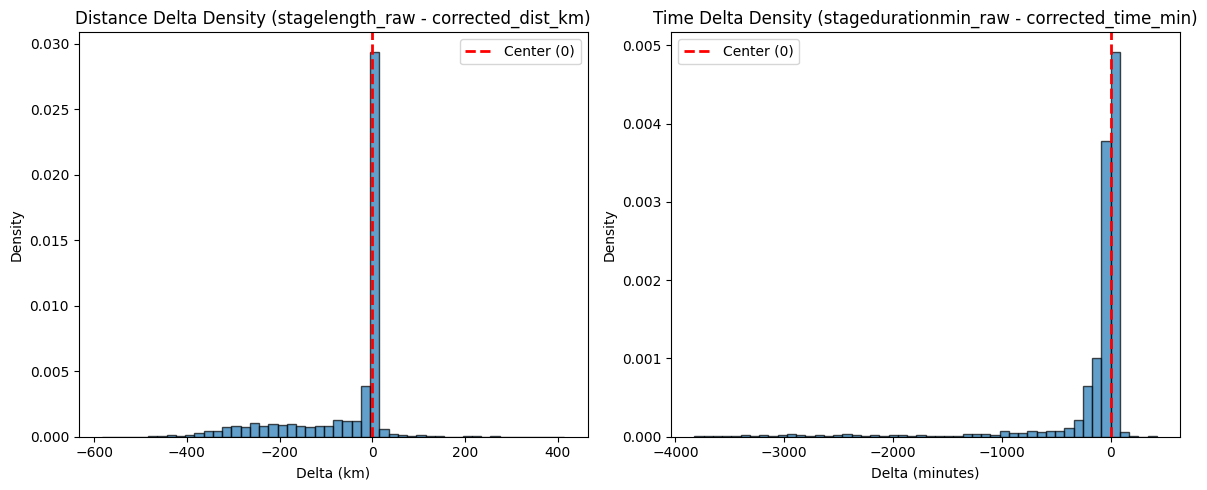

In [30]:
import matplotlib.pyplot as plt

# Plot density histograms for the deltas, highlighting the center (0)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distance delta
dist_delta = RAG['dist_delta'].dropna()
axes[0].hist(dist_delta, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Center (0)')
axes[0].set_title('Distance Delta Density (stagelength_raw - corrected_dist_km)')
axes[0].set_xlabel('Delta (km)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Time delta
time_delta = RAG['time_delta'].dropna()
axes[1].hist(time_delta, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Center (0)')
axes[1].set_title('Time Delta Density (stagedurationmin_raw - corrected_time_min)')
axes[1].set_xlabel('Delta (minutes)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

In [31]:
# 2. Filter for the "Intervention Set"
# CHANGE: Now checking if EITHER distance OR time was corrected/imputed.
# This ensures we capture every row where the pipeline provided new data.
intervention_mask = (RAG['corrected_dist_km'].notna()) | (RAG['corrected_time_min'].notna())
intervention_set = RAG[intervention_mask].copy()

# --- METRIC 1: RECOVERY RATE ---
# We count any row where the LLM flagged it (INVALID or corrected)
total_invalid_flagged = (RAG['llm_verdict'] == 'INVALID').sum() + (RAG['llm_verdict'] == 'corrected').sum()
total_corrected = intervention_set.shape[0]
success_rate = (total_corrected / total_invalid_flagged) * 100

# --- METRIC 2: SPATIAL IMPUTATION (Missing Coords Fixed) ---
# Logic: Originally bad coords -> Now valid coords in the corrected set
bad_coords_mask = intervention_set['flag_coords_bad'] == True
fixed_coords_count = intervention_set[bad_coords_mask].shape[0]

# --- METRIC 3: PHYSICAL PLAUSIBILITY (Speed/Physics Check) ---
def get_speed(dist, mins):
    # Avoid division by zero
    if mins is None or mins <= 0: return 9999 
    return (dist / mins * 60)

# Calculate Before (User) and After (System) speeds
intervention_set['speed_user'] = intervention_set.apply(
    lambda x: get_speed(x['stagelength_raw'], x['stagedurationmin_raw']), axis=1
)
intervention_set['speed_system'] = intervention_set.apply(
    lambda x: get_speed(x['corrected_dist_km'], x['corrected_time_min']), axis=1
)

# Define "Impossible" thresholds (Consistent with your prep logic)
def is_impossible(speed, mode):
    if mode == 1: return speed > 15   # Walk
    if mode == 2: return speed > 60   # Bike
    return speed > 180                # Car

# Count: How many went from IMPOSSIBLE -> POSSIBLE?
intervention_set['impossible_before'] = intervention_set.apply(
    lambda x: is_impossible(x['speed_user'], x['transportmiddel']), axis=1
)
intervention_set['possible_after'] = intervention_set.apply(
    lambda x: not is_impossible(x['speed_system'], x['transportmiddel']), axis=1
)

sanity_restored_count = intervention_set[intervention_set['impossible_before'] & intervention_set['possible_after']].shape[0]

# --- METRIC 4: ERROR MAGNITUDE ---
# Calculate deviations for both DISTANCE and TIME now
intervention_set['diff_km'] = (intervention_set['stagelength_raw'] - intervention_set['corrected_dist_km']).abs()
intervention_set['diff_min'] = (intervention_set['stagedurationmin_raw'] - intervention_set['corrected_time_min']).abs()

total_km_error = intervention_set['diff_km'].sum()
total_min_error = intervention_set['diff_min'].sum()

avg_km_error = intervention_set['diff_km'].mean()
avg_min_error = intervention_set['diff_min'].mean()

print("--- UPDATED THESIS DATA POINTS ---")
print(f"[A] Total Flagged Rows: {total_invalid_flagged}")
print(f"[B] Successfully Corrected: {total_corrected}")
print(f"[C] Pipeline Success Rate: {success_rate:.1f}%")
print(f"[D] Spatial Coordinates Restored: {fixed_coords_count}")
print(f"[E] Physically Impossible Trips Fixed: {sanity_restored_count}")
print(f"[F] Total Distance Error Removed: {total_km_error:,.0f} km")
print(f"[G] Total Time Error Removed: {total_min_error:,.0f} minutes")
print(f"[H] Average Correction: {avg_km_error:.2f} km and {avg_min_error:.1f} min per trip")

--- UPDATED THESIS DATA POINTS ---
[A] Total Flagged Rows: 8051
[B] Successfully Corrected: 8051
[C] Pipeline Success Rate: 100.0%
[D] Spatial Coordinates Restored: 6913
[E] Physically Impossible Trips Fixed: 583
[F] Total Distance Error Removed: 488,603 km
[G] Total Time Error Removed: 1,420,142 minutes
[H] Average Correction: 60.69 km and 176.4 min per trip


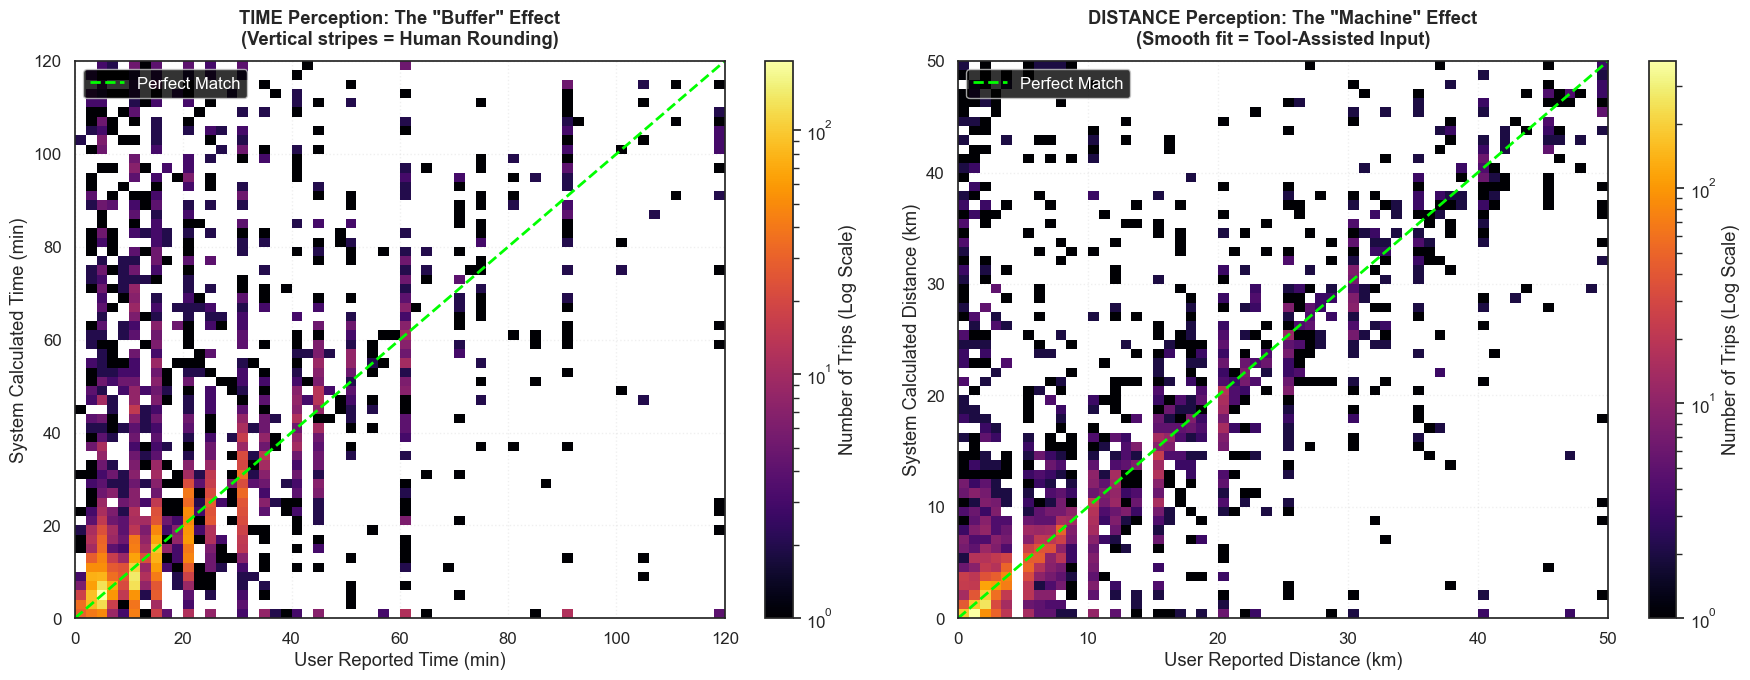

In [32]:
# ==========================================
# IDEA 1: THE REALITY CHECK (Density Matrix)
# ==========================================
sns.set_theme(style="white", font_scale=1.1)


# 1. Filter: Keep rows where EITHER Distance OR Time was corrected
data_viz = RAG[(RAG['corrected_dist_km'].notna()) | (RAG['corrected_time_min'].notna())].copy()

def plot_density_matrix(data, ax, col_user, col_sys, title, max_val, unit_label):
    # Filter view for the plot window to avoid skewing the heatmap
    d = data[(data[col_user] <= max_val) & (data[col_sys] <= max_val)]
    
    # Create the 2D Histogram (Heatmap) with Log Norm
    h = ax.hist2d(
        d[col_user], 
        d[col_sys], 
        bins=60, 
        range=[[0, max_val], [0, max_val]], 
        cmap='inferno', 
        norm=mcolors.LogNorm() 
    )
    
    # 'Perfect Agreement' Line in BRIGHT GREEN
    ax.plot([0, max_val], [0, max_val], color='lime', linestyle='--', linewidth=2, label='Perfect Match')
    
    # Formatting
    ax.set_xlabel(f'User Reported {unit_label}')
    ax.set_ylabel(f'System Calculated {unit_label}')
    ax.set_title(title, fontweight='bold', pad=12)
    
    # Add Colorbar & Legend
    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label('Number of Trips (Log Scale)')
    ax.legend(loc='upper left', frameon=True, facecolor='black', labelcolor='white')
    ax.grid(True, linestyle=':', alpha=0.3)

# Initialize Figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- PLOT 1: TIME (Minutes) ---
# We drop NaNs just for this specific plot to prevent errors
plot_density_matrix(
    data_viz.dropna(subset=['stagedurationmin_raw', 'corrected_time_min']), 
    axes[0], 
    'stagedurationmin_raw', 'corrected_time_min', 
    'TIME Perception: The "Buffer" Effect\n(Vertical stripes = Human Rounding)', 
    120, 
    'Time (min)'
)

# --- PLOT 2: DISTANCE (Kilometers) ---
plot_density_matrix(
    data_viz.dropna(subset=['stagelength_raw', 'corrected_dist_km']), 
    axes[1], 
    'stagelength_raw', 'corrected_dist_km', 
    'DISTANCE Perception: The "Machine" Effect\n(Smooth fit = Tool-Assisted Input)', 
    50, 
    'Distance (km)'
)

plt.tight_layout()
plt.show()

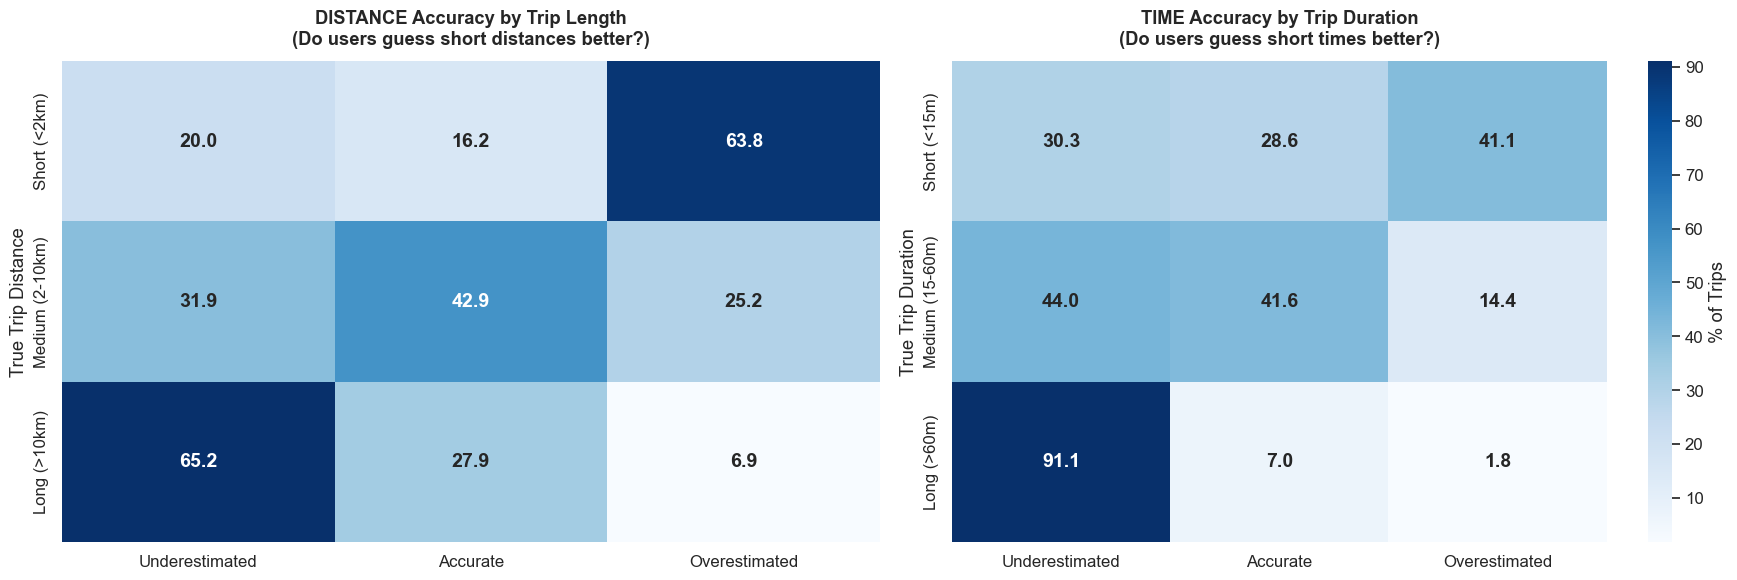

In [33]:
# ==========================================
# IDEA 2: ERROR MAGNITUDE MATRICES
# ==========================================
# "Do users lie more on long trips?"

# 1. PREPARE DISTANCE DATA
# ------------------------
# Drop rows where system distance is 0 to avoid division errors
dist_viz = data_viz[data_viz['corrected_dist_km'] > 0].copy()

# A. Define Trip Size Categories (based on System Truth)
dist_viz['dist_cat'] = pd.cut(
    dist_viz['corrected_dist_km'], 
    bins=[0, 2, 10, 9999], 
    labels=['Short (<2km)', 'Medium (2-10km)', 'Long (>10km)']
)

# B. Calculate % Error: (User - System) / System
dist_viz['pct_error'] = (dist_viz['stagelength_raw'] - dist_viz['corrected_dist_km']) / dist_viz['corrected_dist_km']

# C. Categorize the Error (Tolerance: +/- 20%)
conditions = [
    (dist_viz['pct_error'] < -0.20),
    (dist_viz['pct_error'].between(-0.20, 0.20)),
    (dist_viz['pct_error'] > 0.20)
]
dist_viz['error_type'] = np.select(conditions, ['Underestimated', 'Accurate', 'Overestimated'], default='Accurate')


# 2. PREPARE TIME DATA
# --------------------
# Drop rows where system time is 0
time_viz = data_viz[data_viz['corrected_time_min'] > 0].copy()

# A. Define Duration Categories
time_viz['time_cat'] = pd.cut(
    time_viz['corrected_time_min'],
    bins=[0, 15, 60, 9999],
    labels=['Short (<15m)', 'Medium (15-60m)', 'Long (>60m)']
)

# B. Calculate % Error
time_viz['pct_error'] = (time_viz['stagedurationmin_raw'] - time_viz['corrected_time_min']) / time_viz['corrected_time_min']

# C. Categorize the Error
conditions_time = [
    (time_viz['pct_error'] < -0.20),
    (time_viz['pct_error'].between(-0.20, 0.20)),
    (time_viz['pct_error'] > 0.20)
]
time_viz['error_type'] = np.select(conditions_time, ['Underestimated', 'Accurate', 'Overestimated'], default='Accurate')


# 3. CREATE CROSSTABS (The Matrices)
# ----------------------------------
matrix_dist = pd.crosstab(dist_viz['dist_cat'], dist_viz['error_type'], normalize='index') * 100
matrix_time = pd.crosstab(time_viz['time_cat'], time_viz['error_type'], normalize='index') * 100

# Reorder columns logically
cols_order = ['Underestimated', 'Accurate', 'Overestimated']
matrix_dist = matrix_dist.reindex(columns=cols_order).fillna(0)
matrix_time = matrix_time.reindex(columns=cols_order).fillna(0)


# 4. PLOT
# -------
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distance Accuracy
sns.heatmap(
    matrix_dist, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=axes[0],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[0].set_title('DISTANCE Accuracy by Trip Length\n(Do users guess short distances better?)', fontweight='bold', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('True Trip Distance')

# Plot 2: Time Accuracy
sns.heatmap(
    matrix_time, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': '% of Trips'}, ax=axes[1],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[1].set_title('TIME Accuracy by Trip Duration\n(Do users guess short times better?)', fontweight='bold', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('True Trip Duration')

plt.tight_layout()
plt.show()

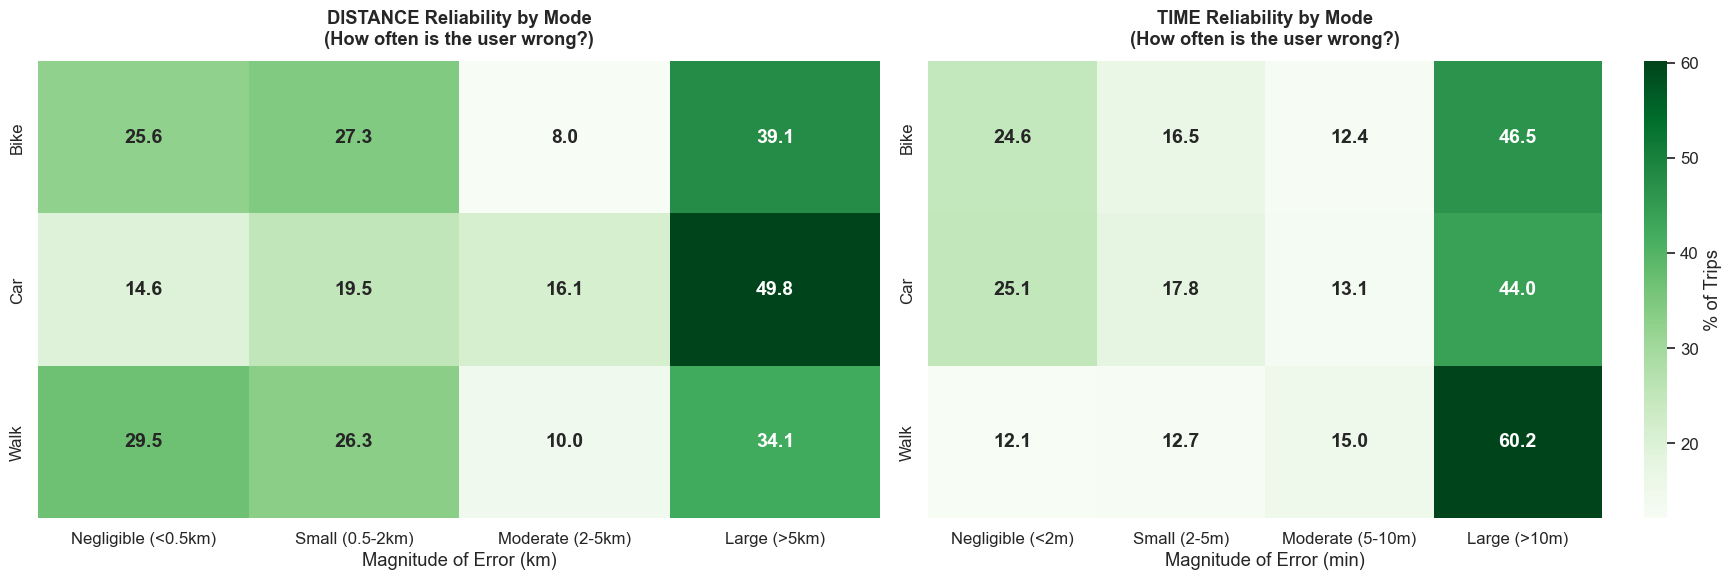

In [34]:
# ==========================================
# IDEA 3: MODE RELIABILITY MATRICES
# ==========================================
# "Which transport mode provides the most trustworthy data?"

# 1. MAP TRANSPORT MODES
# ----------------------
# Ensure we have readable names based on the TU codes
def get_mode_label(code):
    if code == 1: return 'Walk'
    if code == 2: return 'Bike'
    if 3 <= code <= 25: return 'Car'

data_viz['mode_name'] = data_viz['transportmiddel'].apply(get_mode_label)

# Filter out 'Other' to keep the chart clean (focus on main 3 modes)
mode_viz = data_viz[data_viz['mode_name'] != 'Other'].copy()


# 2. PREPARE DISTANCE DATA (Absolute Error)
# -----------------------------------------
# We care about MAGNITUDE of error here (Absolute Difference)
mode_viz['abs_diff_km'] = (mode_viz['stagelength_raw'] - mode_viz['corrected_dist_km']).abs()

# Bin the error magnitude
mode_viz['dist_error_cat'] = pd.cut(
    mode_viz['abs_diff_km'],
    bins=[-0.1, 0.5, 2.0, 5.0, 9999],
    labels=['Negligible (<0.5km)', 'Small (0.5-2km)', 'Moderate (2-5km)', 'Large (>5km)']
)


# 3. PREPARE TIME DATA (Absolute Error)
# -------------------------------------
mode_viz['abs_diff_min'] = (mode_viz['stagedurationmin_raw'] - mode_viz['corrected_time_min']).abs()

# Bin the error magnitude
mode_viz['time_error_cat'] = pd.cut(
    mode_viz['abs_diff_min'],
    bins=[-0.1, 2, 5, 10, 9999],
    labels=['Negligible (<2m)', 'Small (2-5m)', 'Moderate (5-10m)', 'Large (>10m)']
)


# 4. CREATE CROSSTABS
# -------------------
# Normalize='index' gives us the % of trips for that mode
matrix_mode_dist = pd.crosstab(mode_viz['mode_name'], mode_viz['dist_error_cat'], normalize='index') * 100
matrix_mode_time = pd.crosstab(mode_viz['mode_name'], mode_viz['time_error_cat'], normalize='index') * 100


# 5. PLOT
# -------
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distance Reliability
sns.heatmap(
    matrix_mode_dist, annot=True, fmt='.1f', cmap='Greens', cbar=False, ax=axes[0],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[0].set_title('DISTANCE Reliability by Mode\n(How often is the user wrong?)', fontweight='bold', pad=12)
axes[0].set_xlabel('Magnitude of Error (km)')
axes[0].set_ylabel('')

# Plot 2: Time Reliability
sns.heatmap(
    matrix_mode_time, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': '% of Trips'}, ax=axes[1],
    annot_kws={"size": 14, "weight": "bold"}
)
axes[1].set_title('TIME Reliability by Mode\n(How often is the user wrong?)', fontweight='bold', pad=12)
axes[1].set_xlabel('Magnitude of Error (min)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [35]:
show_scrollable(df_corrected)

,SessionId,turid,homeText_raw,workText_raw,startDayText_raw,startstedadrsogeord,startTripText_raw,tiladrsogeord,tiladrtext_raw,transportmiddel,stagelength_raw,stagedurationmin_raw,home_lat,home_lon,work_lat,work_lon,start_lat,start_lon,til_lat,til_lon,calc_dist_geo,dist_start_home,dist_end_home,flag_coords_bad,flag_speed_bad,flag_zero_dist,validation_status,prompt_text,rag_start_address,rag_start_lat,rag_start_lon,rag_start_conf,rag_end_address,rag_end_lat,rag_end_lon,rag_end_conf,rag_prompt_text,llm_full_response,llm_verdict,corrected_dist_km,corrected_time_min,note_correction,speed_old,speed_new,valid_before,valid_after
107,347096,2118225,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",11.0,7.0,15.0,54.834526,11.465634,54.662786,11.351456,54.662786,11.351456,0.000000,4.511256,6110.319369,20.454239,6130.283579,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","K. H. Kofoedsvej 6, 4970 Rødby",54.662618,11.357392,0.870392,"Kolby Hovedgade 8, 8305 Samsø",55.800105,10.555706,0.798605,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,211.6,230.0,osrm_recalc,28.000000,55.200000,True,True
108,347096,2118226,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Plantagevej 1, 4941 Bandholm","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...",11.0,7.0,15.0,54.834526,11.465634,54.662786,11.351456,0.000000,4.511256,54.662786,11.351456,6110.319369,6130.283579,20.454239,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Kolby Hovedgade 8, 8305 Samsø",55.800105,10.555706,0.798605,"K. H. Kofoedsvej 6, 4970 Rødby",54.662618,11.357392,0.870392,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,210.6,229.0,osrm_recalc,28.000000,55.179039,True,True
150,347115,2118279,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,NaN,"toftevangen 77, 4130 viby sjælland",Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,11.0,42.0,40.0,55.545711,12.032662,NaN,NaN,55.545711,12.032662,0.000000,4.511256,6213.935173,0.000000,6213.935173,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Toftevangen 77, 4130 Viby Sjælland",55.545709,12.032664,1.000000,"Stenagergårdsvej 31, 4160 Herlufmagle",55.300867,11.753039,0.887572,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,43.9,44.0,osrm_recalc,63.000000,59.863636,True,True
151,347115,2118280,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,NaN,"toftevangen 77, 4130 viby sjælland",11.0,42.0,40.0,55.545711,12.032662,NaN,NaN,0.000000,4.511256,55.545711,12.032662,6213.935173,6213.935173,0.000000,True,False,False,hard_wrong,"Below is an instruction that describes a task,...","Stenagergårdsvej 31, 4160 Herlufmagle",55.300867,11.753039,0.887572,"Toftevangen 77, 4130 Viby Sjælland",55.545709,12.032664,1.000000,"Below is an instruction that describes a task,...",Verdict: INVALID\nAnalysis: Coordinate mismatc...,corrected,43.3,43.0,osrm_recalc,63.000000,60.418605,True,True
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg",1.0,1.0,2.0,56.178886,9.554954,NaN,NaN,56.178886,9.554954,56.183815,9.545761,0.789938,0.000000,0.789938,False,True,False,hard_wrong,"Below is an instruction that describes a task,...","Kejlstrupvej 15, 8600 Silkeborg",56.178882,9.554949,1.000000,"Nørrevænget 42, 8600 Silkeborg",56.183812,9.545765,1.000000,"Below is an instruction that describes a task,...",Verdict:

In [36]:
df_corrected_sorted = df_corrected.copy()
df_corrected_sorted = df_corrected_sorted.sort_values('corrected_time_min', ascending=False)

In [37]:
df_corrected_sorted = df_corrected_sorted.drop(columns=['startDayText_raw', 'home_lat', 'home_lon', 'work_lat', 'work_lon','calc_dist_geo', 'flag_coords_bad', 'flag_speed_bad', 'flag_zero_dist','validation_status','prompt_text', 'rag_prompt_text','prompt_text', 'llm_full_response', 'llm_verdict', 'note_correction', 'valid_before', 'valid_after'])

In [38]:
for i, col in enumerate(df_corrected_sorted.columns):
    print(f"{i}: {col}")

0: SessionId
1: homeText_raw
2: workText_raw
3: startstedadrsogeord
4: startTripText_raw
5: turid
6: tiladrsogeord
7: tiladrtext_raw
8: transportmiddel
9: stagelength_raw
10: stagedurationmin_raw
11: start_lat
12: start_lon
13: til_lat
14: til_lon
15: dist_start_home
16: dist_end_home
17: rag_start_address
18: rag_start_lat
19: rag_start_lon
20: rag_start_conf
21: rag_end_address
22: rag_end_lat
23: rag_end_lon
24: rag_end_conf
25: corrected_dist_km
26: corrected_time_min
27: speed_old
28: speed_new


In [39]:
new_order = [0, 5, 1, 2, 3, 4, 17, 20, 6, 7, 21, 24, 8, 9, 25, 10, 26, 27, 28, 11, 12, 18, 19, 13, 14, 22, 23, 15, 16]
new_columns = [df_corrected_sorted.columns[i] for i in new_order]
df_corrected_sorted = df_corrected_sorted[new_columns]

In [40]:
show_scrollable(df_corrected_sorted)

,SessionId,turid,homeText_raw,workText_raw,startstedadrsogeord,startTripText_raw,rag_start_address,rag_start_conf,tiladrsogeord,tiladrtext_raw,rag_end_address,rag_end_conf,transportmiddel,stagelength_raw,corrected_dist_km,stagedurationmin_raw,corrected_time_min,speed_old,speed_new,start_lat,start_lon,rag_start_lat,rag_start_lon,til_lat,til_lon,rag_end_lat,rag_end_lon,dist_start_home,dist_end_home
107,347096,2118225,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...",NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...","K. H. Kofoedsvej 6, 4970 Rødby",0.870392,"Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn","Kolby Hovedgade 8, 8305 Samsø",0.798605,11.0,7.0,211.6,15.0,230.0,28.000000,55.200000,54.662786,11.351456,54.662618,11.357392,0.000000,4.511256,55.800105,10.555706,20.454239,6130.283579
108,347096,2118226,"Plantagevej 1, 4941 Bandholm","Kofoedsminde - Udviklingscentret, Højbovej 6, ...","Region Sjællands Hovedkontor, Rødbyhavn","kofoedsmindes hovedkontor, rødbyhavn","Kolby Hovedgade 8, 8305 Samsø",0.798605,NaN,"kofoedsminde - udviklingscentret, højbovej 6, ...","K. H. Kofoedsvej 6, 4970 Rødby",0.870392,11.0,7.0,210.6,15.0,229.0,28.000000,55.179039,0.000000,4.511256,55.800105,10.555706,54.662786,11.351456,54.662618,11.357392,6130.283579,20.454239
150,347115,2118279,"Toftevangen 77, 4130 Viby Sjælland",NaN,NaN,"toftevangen 77, 4130 viby sjælland","Toftevangen 77, 4130 Viby Sjælland",1.000000,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,"Stenagergårdsvej 31, 4160 Herlufmagle",0.887572,11.0,42.0,43.9,40.0,44.0,63.000000,59.863636,55.545711,12.032662,55.545709,12.032664,0.000000,4.511256,55.300867,11.753039,0.000000,6213.935173
151,347115,2118280,"Toftevangen 77, 4130 Viby Sjælland",NaN,Gelsted 4160,stenagergårdsvej\r\ngelsted\r\n4130 herlufmagle,"Stenagergårdsvej 31, 4160 Herlufmagle",0.887572,NaN,"toftevangen 77, 4130 viby sjælland","Toftevangen 77, 4130 Viby Sjælland",1.000000,11.0,42.0,43.3,40.0,43.0,63.000000,60.418605,0.000000,4.511256,55.300867,11.753039,55.545711,12.032662,55.545709,12.032664,6213.935173,0.000000
227,347147,2118373,"Kejlstrupvej 15, 8600 Silkeborg",NaN,NaN,"kejlstrupvej 15, 8600 silkeborg","Kejlstrupvej 15, 8600 Silkeborg",1.000000,"Nørrevænget 42, 8600","nørrevænget 42, 8600 silkeborg","Nørrevænget 42, 8600 Silkeborg",1.000000,1.0,1.0,1.0,2.0,13.0,30.000000,4.615385,56.178886,9.554954,56.178882,9.554949,56.183815,9.545761,56.183812,9.545765,0.000000,0.789938
253,347159,2118403,"Spaden D 3, Høje Taastr., 2630 Taastrup","Frøgård Alle 2, Høje Taastr., 2630 Taastrup",NaN,"frøgård alle 2, høje taastr., 2630 taastrup","Frøgård Alle 2, 2630 Taastrup",0.949174,NaN,"spaden d 3, høje taastr., 2630 taastrup","Høje Taastrup Vej 3E, 2630 Taastrup",0.874649,1.0,2.0,2.5,10.0,30.0,12.000000,5.000000,55.649058,12.262489,55.649059,12.262488,55.651160,12.277754,55.645793,12.296726,0.985799,0.000000
466,347271,2118667,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør",NaN,"Ydunsvej 9, 3000 Helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,NaN,"sundtoldvej 2, 3000 helsingør","Sundtoldvej 2, 3000 Helsingør",1.000000,2.0,1.0,1.0,1.0,6.0,60.000000,10.000000,56.039003,12.594531,56.039002,12.594529,56.041347,12.606025,56.041346,12.606020,0.000000,0.760045
469,347271,2118670,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør",NaN,"ydunsvej 9, 3000 helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,"Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør","Gefionsvej 47A, 3000 Helsingør",1.000000,2.0,1.0,0.6,1.0,3.0,60.000000,12.000000,56.039003,12.594531,56.039002,12.594529,56.039490,12.587380,56.039495,12.587382,0.000000,0.447453
470,347271,2118671,"Ydunsvej 9, 3000 Helsingør","Sundtoldvej 2, 3000 Helsingør","Gefionsvej 47, 3000","gefionsvej 47a, 3000 helsingør","Gefionsvej 47A, 3000 Helsingør",1.000000,NaN,"ydunsvej 9, 3000 helsingør","Ydunsvej 9, 3000 Helsingør",1.000000,2.0,1.0,0.7,1.0,3.0,60.000000,14.000000,56.039490,12.587380,56

In [41]:
df_corrected_sorted.to_excel('corrected_trips_detailed.xlsx', index=False)